## imports

In [ ]:
!pip install emoji
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('portuguese')

from nltk.stem.porter import PorterStemmer
import emoji
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


In [ ]:
import tensorflow as tf

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Carregando os dados

Para os fins a que se destina estre trabalho, iremos utilizar duas bases de dados contendo diversas notícias brasileiras reais e fakes, igualmente distribuidas.



0 - REAL

1 - FAKE

#### Fake.br

Link do projeto: https://github.com/roneysco/Fake.br-Corpus

In [ ]:
# tranformar os textos brutos do fakebr para um dataset
# import os

# fakebr_news = pd.DataFrame(columns=['text'])

# texts_path = [
#     (0, '/content/drive/MyDrive/Mentorama/projeto_final/datasets/fake.br/real/'),
#     (1, '/content/drive/MyDrive/Mentorama/projeto_final/datasets/fake.br/fake/')
# ]

# for label, path in texts_path:
#   for filename in os.listdir(path):
#       with open(os.path.join(path, filename)) as f:
#           observation = f.read()
#           current_df = pd.DataFrame({'text': [observation], 'label': [int(label)]})
#           fakebr_news = fakebr_news.append(current_df, ignore_index=True)

# fakebr_news.to_csv('/content/drive/MyDrive/Mentorama/projeto_final/datasets/fakebr.csv')

In [ ]:
fakebr_news = pd.read_csv('/content/drive/MyDrive/Mentorama/projeto_final/datasets/fakebr.csv', index_col=[0])
fakebr_news

,text,label
0,Julgamento da chapa Dilma-Temer pode resultar ...,0.0
1,Os detetives voluntários que procuram aviões q...,0.0
2,A Polícia Federal atribui crime de corrupção ...,0.0
3,Entender objetivos dos EUA e pressionar Putin:...,0.0
4,Quem é o capitão que liderou rebelião contra o...,0.0
...,...,...
7195,Coreia do Norte ameaça explodir Nova York após...,1.0
7196,Teoria afirma que escolta de Obama era formada...,1.0
7197,Tognolli: Odebrecht vai dar tiro pra todo lado...,1.0
7198,União gastou quase R$ 1 bilhão com diárias par...,1.0


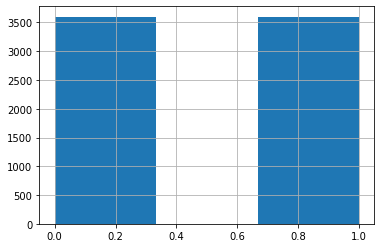

In [ ]:
# verificando a distribuição da variável target
fakebr_news.label.hist(bins=3)

In [ ]:
# categorizando a nosso target
fakebr_news['label'] = pd.Categorical(fakebr_news['label'])
fakebr_news['label'] = fakebr_news.label.cat.codes

In [ ]:
fakebr_news.dtypes

text     object
label      int8
dtype: object

#### FakeRecogna

FakeRecogna é um conjunto de dados composto por notícias reais e falsas. A notícia real não está diretamente ligada às notícias falsas e vice-versa, o que pode levar a uma classificação tendenciosa. A coleta de notícias foi realizada por crawlers desenvolvidos para mineração de páginas de notícias de agências conhecidas e de grande relevância nacional. Os web crawlers foram desenvolvidos com base em cada página analisada, onde as informações extraídas são primeiramente separadas em categorias e depois agrupadas por datas. A pluralidade de notícias em várias páginas e os diferentes estilos de escrita proporcionam ao conjunto de dados uma grande diversidade para análise de processamento de linguagem natural e algoritmos de aprendizado de máquina.

Link do projeto: https://github.com/Gabriel-Lino-Garcia/FakeRecogna

In [ ]:
recogna_news = pd.read_csv('/content/drive/MyDrive/Mentorama/projeto_final/datasets/FakeRecogna_no_removal_words_1_.csv', index_col=[0])

recogna_news['label'] = recogna_news['Classe'].apply(lambda x: 1 if x == 0 else 0)
recogna_news['text'] = recogna_news['Subtitulo'].apply(lambda x: str(x))

recogna_news = recogna_news.drop(['Subtitulo', 'Noticia', 'Categoria', 'Data', 'Autor', 'URL', 'Classe'], axis=1)
recogna_news = recogna_news.reset_index(drop=True)
recogna_news.head(1)

,label,text
0,1,Boato – Está comprovado que a votação sobre o ...


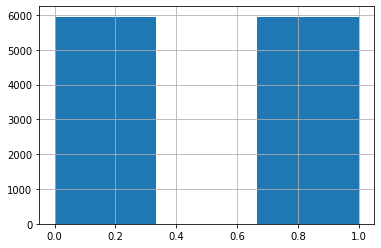

In [ ]:
# verificando a distribuição da variável target
recogna_news.label.hist(bins=3)

In [ ]:
recogna_news.dtypes

label     int64
text     object
dtype: object

In [ ]:
# categorize labels
recogna_news['label'] = pd.Categorical(recogna_news['label'])
recogna_news['label'] = recogna_news.label.cat.codes

recogna_news.head(10)

,label,text
0,1,Boato – Está comprovado que a votação sobre o ...
1,0,"Opção vinha sendo testada no aplicativo, e foi..."
2,0,nan
3,0,nan
4,1,Publicações compartilhadas dezenas de vezes de...
5,0,nan
6,1,Publicações que supostamente provam que eram a...
7,0,nan
8,0,nan
9,1,nan


In [ ]:
recogna_news.shape


(11902, 2)

In [ ]:
recogna_news.dtypes


label      int8
text     object
dtype: object

#### Juntando os dois datasets

In [ ]:
# final_data = pd.concat([recogna_news, fakebr_news], ignore_index=True)
final_data = recogna_news

In [ ]:
# final_data.to_csv('/content/drive/MyDrive/Mentorama/projeto_final/datasets/final_fake+recogna.csv', index=False)

## Explorando os dados

In [ ]:
# final_data = pd.read_csv('/content/drive/MyDrive/Mentorama/projeto_final/datasets/final_fake+recogna.csv')

In [ ]:
import re

def preprocess_text(text, remove_stop = True, stem_words = False, remove_mentions_hashtags = True):
    """
    eg:
    input: preprocess_text("@water #dream hi hello where are you going be there tomorrow happening happen happens",
    stem_words = True)
    output: ['tomorrow', 'happen', 'go', 'hello']
    """

    # Remove emojis
    emoji_pattern = re.compile("[" "\U0001F1E0-\U0001F6FF" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)
    text = "".join([x for x in text if x not in emoji.EMOJI_DATA])

    if remove_mentions_hashtags:
        text = re.sub(r"@(\w+)", " ", text)
        text = re.sub(r"#(\w+)", " ", text)

    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    words = (''.join(nopunct)).split()

    if(remove_stop):
        words = [w for w in words if w not in stop_words]
        words = [w for w in words if len(w) > 2]  # remove a,an,of etc.

    if(stem_words):
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]

    return list(words)

In [ ]:
rows, cols = final_data.shape
final_data['token'] = [preprocess_text(i, stem_words=False) for i in final_data.text]


In [ ]:
final_data.head(5)

,label,text,token
0,1,bomba lira fraudar o votação brasília explodir...,"[bomba, lira, fraudar, vota, bras, lia, explod..."
1,0,o whatsapp liberar quinta-feira atualização ap...,"[whatsapp, liberar, quinta, feira, atualiza, a..."
2,0,debater propor o cidade o campanha prefeitura ...,"[debater, propor, cidade, campanha, prefeitura..."
3,0,o alesp assembleia legislativo paulo aprovar h...,"[alesp, assembleia, legislativo, paulo, aprova..."
4,1,“ fauci aprovar o hidroxicloroquina haver ano ...,"[fauci, aprovar, hidroxicloroquina, ano, curar..."


In [ ]:
final_data['n_words'] = final_data.token.apply(lambda x: len(x))
final_data

,label,text,token,n_words
0,1,bomba lira fraudar o votação brasília explodir...,"[bomba, lira, fraudar, vota, bras, lia, explod...",31
1,0,o whatsapp liberar quinta-feira atualização ap...,"[whatsapp, liberar, quinta, feira, atualiza, a...",37
2,0,debater propor o cidade o campanha prefeitura ...,"[debater, propor, cidade, campanha, prefeitura...",70
3,0,o alesp assembleia legislativo paulo aprovar h...,"[alesp, assembleia, legislativo, paulo, aprova...",41
4,1,“ fauci aprovar o hidroxicloroquina haver ano ...,"[fauci, aprovar, hidroxicloroquina, ano, curar...",87
...,...,...,...,...
11897,0,o encontrar reunir o presidente jair bolsonaro...,"[encontrar, reunir, presidente, jair, bolsonar...",83
11898,0,o reabertura complexo parque disney orlar defi...,"[reabertura, complexo, parque, disney, orlar, ...",71
11899,1,publicação circular rede social pedir o minist...,"[publica, circular, rede, social, pedir, minis...",92
11900,0,o juiz wauner batista ferreiro machadar 3ª var...,"[juiz, wauner, batista, ferreiro, machadar, va...",96


In [ ]:
final_data.n_words.describe()

count    11902.000000
mean        68.181398
std         51.939337
min          0.000000
25%         42.000000
50%         62.000000
75%         82.000000
max       1158.000000
Name: n_words, dtype: float64

In [ ]:
final_data.groupby('label').n_words.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5951.0,81.231054,56.258783,0.0,58.0,73.0,90.0,1158.0
1,5951.0,55.131743,43.475833,1.0,28.0,49.0,69.0,1031.0


Notícias verdadeiras tendem a ter mais palavras do que notícias falsas

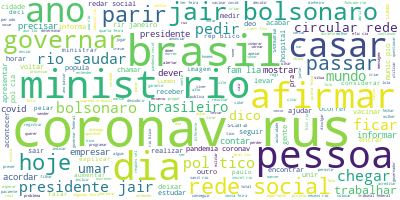

In [ ]:
from wordcloud import WordCloud

# gera um grande texto com todas as palavras de todos os textos
big_text = ','.join(list([' '.join(i) for i in final_data.token.values]))

# wordcloud config
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# gera a wordcloud
wordcloud.generate(big_text)
wordcloud.to_image()


In [ ]:
final_data['token'] = final_data.token.apply(lambda x: ' '.join(x))
final_data

,label,text,token,n_words
0,1,bomba lira fraudar o votação brasília explodir...,bomba lira fraudar vota bras lia explodir vota...,31
1,0,o whatsapp liberar quinta-feira atualização ap...,whatsapp liberar quinta feira atualiza aplicat...,37
2,0,debater propor o cidade o campanha prefeitura ...,debater propor cidade campanha prefeitura fort...,70
3,0,o alesp assembleia legislativo paulo aprovar h...,alesp assembleia legislativo paulo aprovar hoj...,41
4,1,“ fauci aprovar o hidroxicloroquina haver ano ...,fauci aprovar hidroxicloroquina ano curar coro...,87
...,...,...,...,...
11897,0,o encontrar reunir o presidente jair bolsonaro...,encontrar reunir presidente jair bolsonaro man...,83
11898,0,o reabertura complexo parque disney orlar defi...,reabertura complexo parque disney orlar defini...,71
11899,1,publicação circular rede social pedir o minist...,publica circular rede social pedir ministrar s...,92
11900,0,o juiz wauner batista ferreiro machadar 3ª var...,juiz wauner batista ferreiro machadar varar fa...,96


In [ ]:
#final_data.to_csv('/content/drive/MyDrive/Mentorama/projeto_final/datasets/final_fake+recogna.csv', index=False)


## Modelando os dados

In [ ]:
final_data = pd.read_csv('/content/drive/MyDrive/Mentorama/projeto_final/datasets/final_fake+recogna.csv')
final_data

,label,text,token,n_words
0,1,bomba lira fraudar o votação brasília explodir...,bomba lira fraudar vota bras lia explodir vota...,31
1,0,o whatsapp liberar quinta-feira atualização ap...,whatsapp liberar quinta feira atualiza aplicat...,37
2,0,debater propor o cidade o campanha prefeitura ...,debater propor cidade campanha prefeitura fort...,70
3,0,o alesp assembleia legislativo paulo aprovar h...,alesp assembleia legislativo paulo aprovar hoj...,41
4,1,“ fauci aprovar o hidroxicloroquina haver ano ...,fauci aprovar hidroxicloroquina ano curar coro...,87
...,...,...,...,...
19097,1,Coreia do Norte ameaça explodir Nova York após...,coreia norte amea explodir nova york coment ri...,150
19098,1,Teoria afirma que escolta de Obama era formada...,teoria afirma escolta obama formada aliens nin...,111
19099,1,Tognolli: Odebrecht vai dar tiro pra todo lado...,tognolli odebrecht vai dar tiro pra todo lado ...,148
19100,1,União gastou quase R$ 1 bilhão com diárias par...,uni gastou quase bilh rias funcion rios blicos...,96


## Pre Processamento dos dados

Para esta tarefa, iremos quantificar as palavras existentes no texto, dividí-las em grupos de 10 palavras e encontrar padrões nas intenções do texto

Para isso iremos iremos transformar os textos em vetores binários com tamanho padronizado, necessário para o treinamento do modelo.

#### Vetorizando cada palavra.
Aqui, como cada documento tem um número diferente de palavras, vamos ter matrizes com diferentes dimensões. Nosso objetivo final é conseguir representar cada documento como um vetor que resume o documento. Ou seja, queremos representar diferentes matrizes como vetores. Existem várias formas de fazer isso (média dos vetores, média ponderada pelo TF-IDF, PCA...), mas nesse teste vamos fazer uma média simples.

#### Modelo proposto pelo curso utilizando o spacy

In [ ]:
!python -m spacy download pt_core_news_md


2022-09-21 16:28:40.506806: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 14.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [ ]:
import spacy
from spacy.lang.pt.examples import sentences

nlp = spacy.load("pt_core_news_md")

# definindo função que retorna os vetores para cada palavra:
def vec(s):
    return nlp.vocab[s].vector

In [ ]:
vec_size = 300
rows, cols = final_data.shape

list_of_matrix = []

corpus = final_data['token'].apply(lambda x: str(x).split(' '))
for corpus in corpus:
    matrix = np.empty([len(corpus), vec_size])
    for idx, word in enumerate(corpus):
        matrix[idx,:] = vec(word)
    list_of_matrix.append(matrix)

final_feature_matrix = np.empty([rows, vec_size])

for row in range(rows):
    final_feature_matrix[row,:] = list_of_matrix[row].mean(axis = 0)

final_feature_matrix.shape


(19102, 300)

In [ ]:
#split train test val
ds_train, ds_test, y_train, y_test = train_test_split(final_feature_matrix, final_data['label'])

# split validation set
ds_test, ds_val, y_test, y_val = train_test_split(ds_test, y_test)

print(ds_train.shape, ds_test.shape, ds_val.shape)

(14326, 300) (3582, 300) (1194, 300)


In [ ]:
# make a tensor dataset and split into batches

batch_size = 32

raw_train_ds = tf.data.Dataset.from_tensor_slices((ds_train, y_train.values))
raw_test_ds = tf.data.Dataset.from_tensor_slices((ds_test, y_test.values))
raw_val_ds = tf.data.Dataset.from_tensor_slices((ds_val, y_val.values))

raw_train_ds = raw_train_ds.batch(batch_size)
raw_test_ds = raw_test_ds.batch(batch_size)
raw_val_ds = raw_val_ds.batch(batch_size)

for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Notícia: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])


#### Modelo proposto pelo tensorflow

In [ ]:
final_data['token'] = final_data.token.apply(lambda x: str(x))

In [ ]:
#split train test val
ds_train, ds_test = train_test_split(final_data)

# split validation set
ds_test, ds_val = train_test_split(ds_test)

print(ds_train.shape, ds_test.shape, ds_val.shape)

(14326, 4) (3582, 4) (1194, 4)


In [ ]:
ds_train.dtypes

label       int64
text       object
token      object
n_words     int64
dtype: object

In [ ]:
# make a tensor dataset and split into batches

batch_size = 32

raw_train_ds = tf.data.Dataset.from_tensor_slices((ds_train.token, ds_train.label.values))
raw_test_ds = tf.data.Dataset.from_tensor_slices((ds_test.token, ds_test.label.values))
raw_val_ds = tf.data.Dataset.from_tensor_slices((ds_val.token, ds_val.label.values))

raw_train_ds = raw_train_ds.batch(batch_size)
raw_test_ds = raw_test_ds.batch(batch_size)
raw_val_ds = raw_val_ds.batch(batch_size)

for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Notícia: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])


Notícia:  b'bibi ferreiro criticar machismo dilma condenar golpe'
Label: 1
Notícia:  b'joyce ramirez maicon juc receber semana not cia pai gostar filhar antonella ramirez juc prestar completar vidar beber nascer anticorpo covid prote confirmar segunda feira sair resultar exame sorologia antonella gente ficar feliz emocionar realmente resumir maicon sentimento casal cruzeiro sul acre joyce gravidez ect pico vulo fecundar alojar tero abortar espont neo ano gravidez considerar riscar sintoma gripar forte fevereiro ano gesta casal ficar preocupar'
Label: 0
Notícia:  b'organiza mundial saudar oms afirmar hoje propaga casar coronav rus pessoa chinar fagulhar tornar inc ndio humanar deixar epidemiar sair controlar prov ncia chin hubei epicentro surtir coronav rus registrar casar morte fevereiro informar autoridade saudar ter feira hor rio voltar hor rio bras lia hoje casar confirmar chinar morte casar incluir morte diretor geral oms tedros adhanom ghebreyesus morto epidemiar aumentar domingo 

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Notícia: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])


Notícia:  b'bibi ferreiro criticar machismo dilma condenar golpe'
Label: 1
Notícia:  b'joyce ramirez maicon juc receber semana not cia pai gostar filhar antonella ramirez juc prestar completar vidar beber nascer anticorpo covid prote confirmar segunda feira sair resultar exame sorologia antonella gente ficar feliz emocionar realmente resumir maicon sentimento casal cruzeiro sul acre joyce gravidez ect pico vulo fecundar alojar tero abortar espont neo ano gravidez considerar riscar sintoma gripar forte fevereiro ano gesta casal ficar preocupar'
Label: 0
Notícia:  b'organiza mundial saudar oms afirmar hoje propaga casar coronav rus pessoa chinar fagulhar tornar inc ndio humanar deixar epidemiar sair controlar prov ncia chin hubei epicentro surtir coronav rus registrar casar morte fevereiro informar autoridade saudar ter feira hor rio voltar hor rio bras lia hoje casar confirmar chinar morte casar incluir morte diretor geral oms tedros adhanom ghebreyesus morto epidemiar aumentar domingo 

In [ ]:
from tensorflow import keras
from keras.layers import TextVectorization

VOCAB_SIZE = 100
MAX_SEQUENCE_LENGTH = 50

# vetorizador binário
binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

# vetorizador inteiro
int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

# funcoes para auxiliar na vetorização
def binary_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), label

def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label


In [ ]:
# adaptando o vetorizador
train_text = raw_train_ds.map(lambda text, labels: text)

binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)


In [ ]:
# vamos ver um exemplo da vetorização
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]

print("Notícia", first_question)
print("Label", first_label)
print()

print("'binary' vectorized question:",
      binary_vectorize_text(first_question, first_label)[0])
print()
print("'int' vectorized question:",
      int_vectorize_text(first_question, first_label)[0])


Notícia tf.Tensor(b'bibi ferreiro criticar machismo dilma condenar golpe', shape=(), dtype=string)
Label tf.Tensor(1, shape=(), dtype=int64)

'binary' vectorized question: tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]], shape=(1, 100), dtype=float32)

'int' vectorized question: tf.Tensor(
[[ 1  1  1  1 54  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]], shape=(1, 50), dtype=int64)


In [ ]:
# vamos ver um exemplo do vocabulário
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[12])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[31])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))


1289 --->  vel
313 --->  hoje
Vocabulary size: 100


In [ ]:
# aplicando a vetorização em todos os datasets

binary_train_ds = raw_train_ds.map(binary_vectorize_text)
binary_val_ds = raw_val_ds.map(binary_vectorize_text)
binary_test_ds = raw_test_ds.map(binary_vectorize_text)

int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)


In [ ]:
# otimizando o algoritmo
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

binary_train_ds = configure_dataset(binary_train_ds)
binary_val_ds = configure_dataset(binary_val_ds)
binary_test_ds = configure_dataset(binary_test_ds)

int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)


## Modelagem do Algoritmo

#### helpers

In [ ]:
# vectorize function
import re
def preprocess_text(text, remove_stop = True, stem_words = False, remove_mentions_hashtags = True):
    """
    eg:
    input: preprocess_text("@water #dream hi hello where are you going be there tomorrow happening happen happens",
    stem_words = True)
    output: ['tomorrow', 'happen', 'go', 'hello']
    """

    # Remove emojis
    text = str(text)
    emoji_pattern = re.compile("[" "\U0001F1E0-\U0001F6FF" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)
    text = "".join([x for x in text if x not in emoji.EMOJI_DATA])

    if remove_mentions_hashtags:
        text = re.sub(r"@(\w+)", " ", text)
        text = re.sub(r"#(\w+)", " ", text)

    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    words = (''.join(nopunct)).split()

    if(remove_stop):
        words = [w for w in words if w not in stop_words]
        words = [w for w in words if len(w) > 2]  # remove a,an,of etc.

    if(stem_words):
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]

    return list(words)


custom_vectoryze_layer = tf.keras.layers.Lambda(preprocess_text, name="custom_vectoryze_layer")

In [ ]:
import keras
from matplotlib import pyplot as plt

def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

#### RNN Classificador - Tensorflow


https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [ ]:
# vetorizador padrao
VOCAB_SIZE = 1000
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
vectorize_layer.adapt(raw_train_ds.map(lambda text, label: text))

In [ ]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])


[0.00085553]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])


[0.0292281]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [ ]:
history = model.fit(raw_train_ds, epochs=3,
                    validation_data=raw_test_ds,
                    validation_steps=30)


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


ValueError: ignored

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


In [ ]:
test_loss, test_acc = model.evaluate(raw_test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


ValueError: ignored

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([input()]))
predictions


Dr. Ray peita Bolsonaro, chama-o de conservador fake em entrevista a Danilo Gentili e divide a direita.  Este site vem avisando Jair Bolsonaro que ele deveria abandonar a pauta estatista de vez e fazer um discurso mais convincente para aquela boa parte dos liberais e conservadores do Brasil que querem se ver livres das amarras estatais.  Tudo bem que as pesquisas ainda dizem que a maior parte do povo é contra as privatizações, mas o índice (pouco mais de 50% do povo) é fácil de ser revertido. Ademais, Bolsonaro deveria falar para direitistas em vez de focar tanto em petistas arrependidos.  Recentemente ele disse que pensaria 200 vezes antes de privatizar a Petrobrás para que ela não caia nas mãos de chineses (ou algo do tipo). Deveria ter dito: Eu garanto a privatização da Petrobrás, e também garanto que chineses não irão comprá-la. Isso não deixaria brechas. Do jeito que ele falou, parece que o suposto medo de venda aos chineses é pretexto para evitar a privatização.  Seja lá 

array([[2.2933543]], dtype=float32)

#### Modelo Regressão Linear

Epoch 1/10
448/448 [==============================] - 4s 8ms/step - loss: 0.5755 - accuracy: 0.6889 - val_loss: 0.4462 - val_accuracy: 0.8325
Epoch 2/10
448/448 [==============================] - 2s 5ms/step - loss: 0.4058 - accuracy: 0.8413 - val_loss: 0.3730 - val_accuracy: 0.8576
Epoch 3/10
448/448 [==============================] - 2s 5ms/step - loss: 0.3612 - accuracy: 0.8536 - val_loss: 0.3478 - val_accuracy: 0.8635
Epoch 4/10
448/448 [==============================] - 3s 6ms/step - loss: 0.3440 - accuracy: 0.8579 - val_loss: 0.3368 - val_accuracy: 0.8626
Epoch 5/10
448/448 [==============================] - 3s 7ms/step - loss: 0.3359 - accuracy: 0.8591 - val_loss: 0.3314 - val_accuracy: 0.8618
Epoch 6/10
448/448 [==============================] - 3s 6ms/step - loss: 0.3318 - accuracy: 0.8605 - val_loss: 0.3286 - val_accuracy: 0.8635
Epoch 7/10
448/448 [==============================] - 3s 6ms/step - loss: 0.3295 - accuracy: 0.8602 - val_loss: 0.3272 - val_accuracy: 0.8643
Epoch 

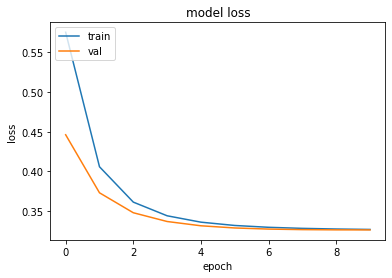

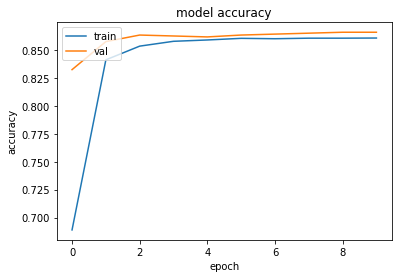

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import losses

binary_model = tf.keras.Sequential([
    layers.Dense(2)
    ])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

history = binary_model.fit(
    binary_train_ds, validation_data=binary_val_ds, epochs=10)
plot_loss(history)
plot_accuracy(history)

In [ ]:
print("Linear model on binary vectorized data:")
print(binary_model.summary())


Linear model on binary vectorized data:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 202
Trainable params: 202
Non-trainable params: 0
_________________________________________________________________
None


[]

#### Modelo Convolucional de 1 Dimensão

Epoch 1/10
448/448 [==============================] - 4s 7ms/step - loss: 0.4919 - accuracy: 0.7535 - val_loss: 0.4171 - val_accuracy: 0.8090
Epoch 2/10
448/448 [==============================] - 2s 5ms/step - loss: 0.4263 - accuracy: 0.8004 - val_loss: 0.4017 - val_accuracy: 0.8166
Epoch 3/10
448/448 [==============================] - 2s 5ms/step - loss: 0.4060 - accuracy: 0.8135 - val_loss: 0.3936 - val_accuracy: 0.8174
Epoch 4/10
448/448 [==============================] - 2s 5ms/step - loss: 0.3920 - accuracy: 0.8212 - val_loss: 0.3894 - val_accuracy: 0.8199
Epoch 5/10
448/448 [==============================] - 2s 5ms/step - loss: 0.3791 - accuracy: 0.8307 - val_loss: 0.3866 - val_accuracy: 0.8199
Epoch 6/10
448/448 [==============================] - 2s 5ms/step - loss: 0.3659 - accuracy: 0.8383 - val_loss: 0.3839 - val_accuracy: 0.8258
Epoch 7/10
448/448 [==============================] - 2s 5ms/step - loss: 0.3522 - accuracy: 0.8462 - val_loss: 0.3820 - val_accuracy: 0.8266
Epoch 

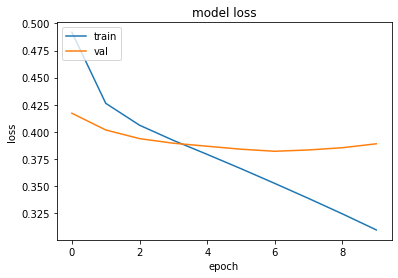

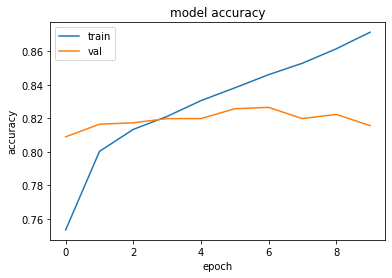

In [ ]:
def create_model(vocab_size, num_labels):
  model = tf.keras.Sequential([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ])
  return model

# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=2)
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
history = int_model.fit(int_train_ds, validation_data=int_val_ds, epochs=10)
plot_loss(history)
plot_accuracy(history)

In [ ]:
print("ConvNet model on int vectorized data:")
print(int_model.summary())


ConvNet model on int vectorized data:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          6464      
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          20544     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 27,138
Trainable params: 27,138
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
binary_loss, binary_accuracy = binary_model.evaluate(binary_test_ds)
int_loss, int_accuracy = int_model.evaluate(int_test_ds)

print("Binary model accuracy: {:2.2%}".format(binary_accuracy))
print("Int model accuracy: {:2.2%}".format(int_accuracy))


112/112 [==============================] - 0s 4ms/step - loss: 0.4249 - accuracy: 0.7990
Binary model accuracy: 85.15%
Int model accuracy: 79.90%


In [ ]:
binary_metrics = {
    'loss': binary_loss, 'accuracy': binary_accuracy
}

int_metrics = {
    'loss': int_loss, 'accuracy': int_accuracy
}
import json

with open('/content/drive/MyDrive/Mentorama/projeto_final/binary_metrics.json', 'w') as fp:
  json.dump(binary_metrics, fp)

with open('/content/drive/MyDrive/Mentorama/projeto_final/int_metrics.json', 'w') as fp:
  json.dump(int_metrics, fp)



#### Modelo MLPClassifier


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# um classificador linear que utiliza o Gradiente Descendente Estocástico como método de treino.
# Por padrão, utiliza o estimador SVM.
from sklearn.linear_model import SGDClassifier
# Uma rede neural Perceptron Multicamadas
from sklearn.neural_network import MLPClassifier

vectorizer = TfidfVectorizer()
X_train_tfidf_vectorize = vectorizer.fit_transform(ds_train.token)

In [ ]:
# Aqui nós treinamos o classificador
#clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(70, ), random_state=1, verbose=True)
clf_history = clf.fit(X_train_tfidf_vectorize, ds_train.label.values)

In [ ]:
from sklearn import metrics

vect_transform = vectorizer.transform(ds_val.token.values)
predicted = clf.predict(vect_transform)


print(metrics.classification_report(ds_val.label.values, predicted))

print(clf.classes_)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       581
           1       0.96      0.94      0.95       613

    accuracy                           0.95      1194
   macro avg       0.95      0.95      0.95      1194
weighted avg       0.95      0.95      0.95      1194

[0 1]


In [ ]:
# export model metrics
export_metrics = {
    'precision': metrics.precision_score(ds_val.label.values, predicted),
    'recall': metrics.recall_score(ds_val.label.values, predicted)
    }

with open('metrics_clf.json', 'w') as fp:
  json.dump(export_metrics, fp)

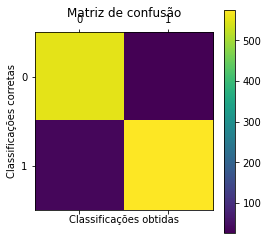

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(ds_val.label, predicted)

plt.matshow(confusion_matrix)
plt.title("Matriz de confusão")
plt.colorbar()
plt.ylabel("Classificações corretas")
plt.xlabel("Classificações obtidas")
plt.show()

In [ ]:
docs_new = [
    input(),
]

X_new_tfidf_vectorize = vectorizer.transform(docs_new)

predicted = clf.predict(X_new_tfidf_vectorize)
print(predicted)

# for doc, category in zip(docs_new, predicted):
#     print('%r => %s' % (doc, ds_train.target_names[label]))

KeyboardInterrupt: ignored

### Modelo Final



In [ ]:
export_model = tf.keras.Sequential(
    [binary_vectorize_layer, binary_model,
     layers.Activation('softmax')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print("Accuracy: {:2.2%}".format(binary_accuracy))


112/112 [==============================] - 1s 5ms/step - loss: 0.3357 - accuracy: 0.8515
Accuracy: 85.15%


In [ ]:
predicted_scores = export_model.predict([input()])
predicted_labels = tf.argmax(predicted_scores, axis=1)

print([i.round(2) for i in predicted_scores[0]])


KeyboardInterrupt: ignored

In [ ]:
export_model_alt = tf.keras.Sequential(
    [int_vectorize_layer, int_model,
     layers.Activation('softmax')])

export_model_alt.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model_alt.evaluate(raw_test_ds)
print("Accuracy: {:2.2%}".format(int_accuracy))


112/112 [==============================] - 1s 8ms/step - loss: 0.4249 - accuracy: 0.7990
Accuracy: 79.90%


In [ ]:
# salvando modelo
export_model.save('/content/drive/MyDrive/Mentorama/projeto_final/modelo_final_0')
export_model.save('/content/drive/MyDrive/Mentorama/projeto_final/modelo_final_alt_0')

#### Save to production

In [ ]:
from joblib import dump, load

In [ ]:
dump(export_model, '/content/drive/MyDrive/Mentorama/projeto_final/fake-detector_v0.joblib')
dump(export_model_alt, '/content/drive/MyDrive/Mentorama/projeto_final/fake-detector_alt_v0.joblib')

['/content/drive/MyDrive/Mentorama/projeto_final/fake-detector_alt_v0.joblib']

## ONLINE API TEST


https://classificador-fakenews.herokuapp.com